# Set Up and Run Delta Siege

## Set up Mechanism and Search Space

Allow for the specificationf: o
* An implementation of a (floating point-insecure) Gaussian noise adding mechanismf:
* The range of DP-parameters which is searched
* The inputs to the mechanism which is tested

### A Floating Point Insecure Gaussian Mechanism

In [1]:
import numpy as np
from deltasiege.mechanism import Mechanism

class GaussianMechanismExample(Mechanism):
    """
    An example (floating point insecure) implementation of the Gaussian mechanism
    as given in https://www.nowpublishers.com/article/Details/TCS-042
    """
    
    def _init_helper(self, epsilon: float, delta : float, sensitivity : float) -> None:
        """
        Initialization helper. Do not overwrite __init__
        """
        self.sensitivity = sensitivity
        self.std = self.guarantee_(epsilon, delta)
        super()._init_helper(epsilon, delta)
    
    def __call__(self, x : float, n: int) -> np.ndarray:
        """
        The specific mechanism - Gaussian noise is added to x
        n samples are drawn.
        """
        std = self.guarantee_(self.epsilon, self.delta)
        return x + np.random.normal(0, std, (n,))
    
    def constraint(self, epsilon : float, delta : float) -> bool:
        """
        Returns if epsilon and delta are valid DP parameters for the mechanism
        For this mechanism it must hold that 0 <= epsilon, delta <= 1
        """
        return 0 <= epsilon <= 1 and 0 <= delta <= 1
        
    def guarantee_(self, epsilon : float, delta : float) -> float:
        """
        A mapping of (epsilon, delta) to a parameter rho, which uniquely specifies the privacy level
        Is non-increasing in both epsilon and delta.
        For the classical Gaussian mechanism, one possible parameter is the standard deviation.
        """
        if epsilon <= 0 or delta <= 0:
            return float("inf")

        return np.sqrt(2 * np.log(1.25 / delta) * np.square(self.sensitivity / epsilon))
    
    def perturb_delta(self, new_delta : float) -> float:
        """
        Returns a epsilon value such that self.guarantee(epsilon, new_delta) == self.guarantee(self.epsilon, self.delta)
        """

        # Can't have a new delta
        if new_delta <= 0:
            return None

        # Use the explicit formula
        new_epsilon = self.sensitivity / self.std * np.sqrt(2 * np.log(1.25 / new_delta))

        # Epsilon values are only valid up to 1
        if new_epsilon > 1.0:
            return None
        else:
            return new_epsilon

    def perturb_epsilon(self, new_epsilon : float) -> float:
        """
        Returns a delta value such that self.guarantee(epsilon, new_delta) == self.guarantee(self.epsilon, self.delta)
        """

        # Can't have a new delta
        if new_epsilon <= 0 or new_epsilon > 1:
            return None

        # Use the explicit formula
        new_delta = np.exp(-0.5 * np.square(new_epsilon * self.std / self.sensitivity)) * 1.25

        return new_delta

# DP Parameters and Search Space

In [2]:
from deltasiege.ddsampler import SimpleSampler

# Basic parameters to the model - these are the hyperparameters which define the method
# We optimize over the hyperparameters to find the largest violation
# Each hyperparameter is given as a range (low, high) and we use Optuna to optimize over them
epsilon_0, delta_0 = 0.1, 0.1
epsilon_range = (epsilon_0, epsilon_0)
delta_range = (delta_0, delta_0)
sensitivity_range = (1.0,  1.0)

# Input pairs to the mechanism (a, a') are also treated as hyper-parameters and must be given as a list of pairs
input_pairs = [(0.0, 1.0)]


# Set up sampler
search_space = SimpleSampler(
    GaussianMechanismExample,
    epsilon=epsilon_range,
    delta=delta_range,
    sensitivity=sensitivity_range,
    input_pairs=input_pairs
)

## Set up Classifier
This is in principle the learning method LearnP from the paper which approximates p(a | b). It can bese any classifier which is compatible with Sklearn's classifier inteface, 
i.e. it must have the methods ```fit``` and ```predict_proba```.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from deltasiege.classifiers import SklearnClassifier, BitPatternFeatureTransformer
from deltasiege.attack import WitnessOptimization, LinesearchEstimator

# Make a simple pipeline
# First transform input to its bit representation, then apply logistic regresslization
sklearn_factory = SklearnClassifier.get_factory(
    classifier=Pipeline([("bit_transformer", BitPatternFeatureTransformer()), ("log_reg", LogisticRegression())])
)

# Set up the witness type
witness_factory = WitnessOptimization.get_factory(estimator=LinesearchEstimator())

## Set up and run Delta Siege itself

Combine the previous setup into the DeltaSiege class and set up the folder structure

In [4]:
from pathlib import Path

from deltasiege import DeltaSiege
from deltasiege.utils import Config
from deltasiege.logging import Logger

# Use deltasiege_runs as base folder to store results
# Can drop to pass a folder which makes all results to only be kept in memory
!rm -rf deltasiege_runs
base_folder = Path("deltasiege_runs")
base_folder.mkdir(exist_ok=True, parents=True)

# See the definition for a detailed overview of config parameters
n = 1_000_000
config = Config(
    n_train=n, n_init=n, 
    n_check=n, n_final=n,
    batch_size=n // 10,
    n_jobs=1,
)

# Set up the search
deltasiege = DeltaSiege(
    config = config, 
    search_space = search_space, 
    classifier_factories = sklearn_factory,
    logger = Logger(Logger.State.SILENT),  # Surpresses  all outputs. Can be VERBOSE, SILENT, DOWN
    base_folder = base_folder
)

deltasiege_run = deltasiege.run("DeltaSiege", witnesses_factories=witness_factory)

[I 2023-10-25 00:45:46,414] A new study created in memory with name: no-name-0c173175-a925-4132-8342-3da09211ff7c
[I 2023-10-25 00:46:01,864] Trial 0 finished with value: 0.1212326022437514 and parameters: {'input_pair': 0, 'epsilon': 0.1, 'delta': 0.1, 'sensitivity': 1.0}. Best is trial 0 with value: 0.1212326022437514.
[I 2023-10-25 00:46:01,915] A new study created in memory with name: no-name-e07c3d01-aaaa-4633-92ed-d312bad94e64
[I 2023-10-25 00:46:16,770] Trial 0 finished with value: 0.43397657238920295 and parameters: {'input_pair': 0, 'epsilon': 0.1, 'delta': 0.1, 'sensitivity': 1.0}. Best is trial 0 with value: 0.43397657238920295.
[I 2023-10-25 00:46:16,818] A new study created in memory with name: no-name-a3fc8123-0659-46a2-b627-b5321a71b340
[I 2023-10-25 00:46:31,673] Trial 0 finished with value: 1.3921116516366139 and parameters: {'input_pair': 0, 'epsilon': 0.1, 'delta': 0.1, 'sensitivity': 1.0}. Best is trial 0 with value: 1.3921116516366139.
[I 2023-10-25 00:46:31,724] A

## Plot the Results
Visualize the found violations in (epsilon, delta)-spaceon

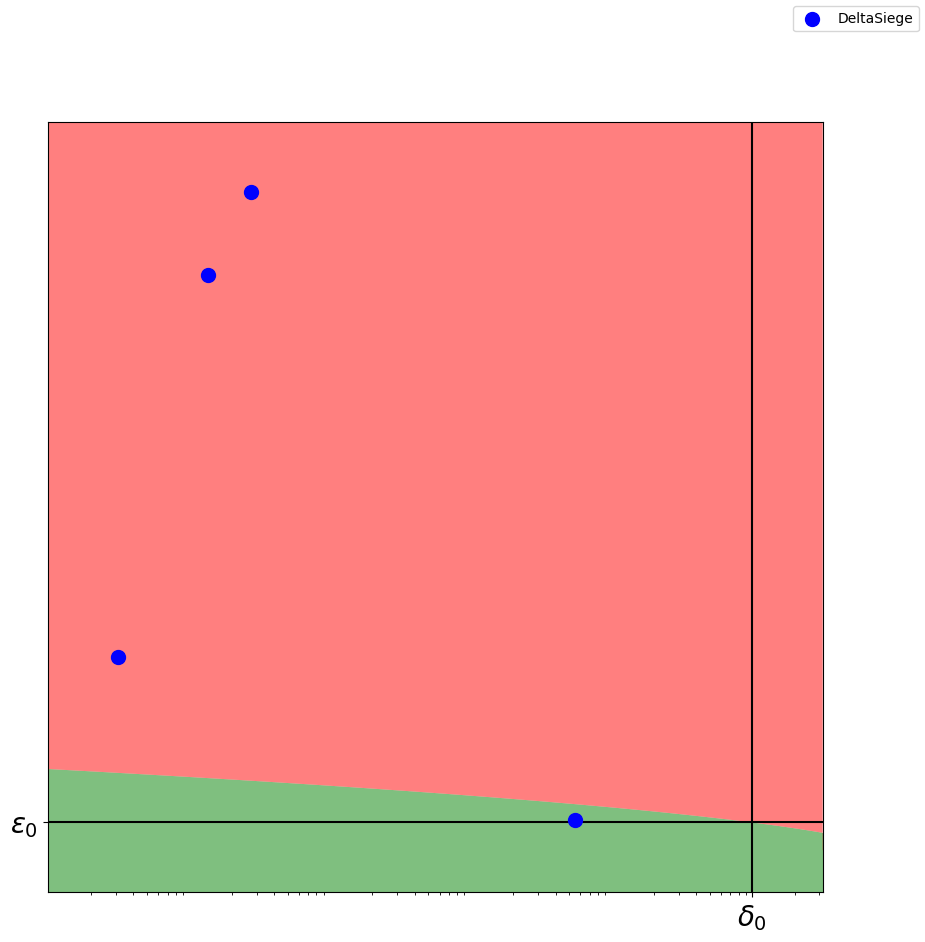

In [5]:
from deltasiege.utils.plot_multiple_trials import plot_all_trials

# Plot all the results
# Can swap 90 degrees by changing x_is_delta
x_is_delta = True
fig, ax = plot_all_trials(
    (deltasiege_run, "DeltaSiege", "o", "blue"),
    x_is_delta=x_is_delta,
)

# Add ticks and labels
if x_is_delta:
    ax.set_xticks([delta_0]) 
    ax.set_xticklabels(["$\\delta_0$"], fontsize=20)
    ax.set_yticks([epsilon_0]) 
    ax.set_yticklabels(["$\\epsilon_0$"], fontsize=20)
else:
    ax.set_xticks([epsilon_0]) 
    ax.set_xticklabels(["$\\epsilon_0$"], fontsize=20)
    ax.set_yticks([delta_0]) 
    ax.set_yticklabels(["$\\delta_0$"], fontsize=20)

# Add legend and plot
fig.legend()
fig.show()

## Anylize the Weights

Run the search by the method of DP-Sniper, where violations can only be established by finding a witness where
$\epsilon_0 < \epsilon_1$ and $\delta_0 = \delta_1$

In [11]:
for experiment in deltasiege_run.experiments:
    for trial in experiment.trials:

        # Extract logistic regression
        trained_clf = trial.witnesses[trial.best_witness_idx].classifier.classifier
        log_reg = trained_clf.steps[1][1]

        # Get weights and intercept
        W, b = log_reg.coef_ , log_reg.intercept_
        
        # Analyze the weights ....witness)